# Road Point Cloud Classification
1. Data Loader
2. Tree-based methods and SVM
3. Convolutional Neural Network


In [1]:
#install required packages
%pip install -r requirements.txt

  Using cached torchvision-0.22.1-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement open3d (from versions: none)
ERROR: No matching distribution found for open3d


In [ ]:
# Basic data processing & preparation functionality
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import cv2

# Visualization
import seaborn as sns
import plotly.express as px
import plotly.colors as pc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import open3d as o3d

# Measurements of time to fit a model
import time

#   Tree-based methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#   SVM related methods
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

# Standard test dataset
from sklearn.datasets import load_iris

# Data preprocessing
from sklearn.model_selection import train_test_split

# Dataset tuning
from sklearn.decomposition import PCA

# Model tuning
from sklearn.model_selection import GridSearchCV

# Metric for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Deep learning methods
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
#from torchvision import transforms

In [3]:
# --- Road Point Cloud Classification - Data Loader --- (Jonas)

# Function to load all point clouds from a folder
def load_point_clouds(labels, folder_path="dataset/"):
    """
    Loads all .npy point cloud files from the specified folder.

    Args:
        folder_path (str): Path to the folder containing .npy files.

    Returns:
        list of np.ndarray: List of loaded point cloud arrays.
    """
    point_clouds = []
    for label in labels:
        folder = f"{folder_path}{label}"  # Adjust the folder paths as needed
        for filename in os.listdir(folder):
            if filename.endswith('.npy'):
                file_path = os.path.join(folder, filename)
                data = np.load(file_path)
                # print(data.shape)  # Print shape of each loaded point cloud
                label_vector = np.zeros((data.shape[0], 1))  # Create a label vector of zeros
                label_vector.fill(labels.index(label))  # Fill the label vector with the index of the label
                data = np.hstack((data, label_vector))  # Concatenate label vector to the point cloud data
                # print(data.shape)  # Print shape after concatenation
                point_clouds.append(data)
    return point_clouds

# def visualize_point_cloud(points, title="Point Cloud", color='b', s=1):
#     """
#     Visualizes a 3D point cloud using open3d.

#     Args:
#         points (np.ndarray): Array of shape (N, 3) or (N, >=3) with x, y, z coordinates.
#         title (str): Plot title.
#         color (str or array): Color of points.
#         s (float): Marker size.
#     """
#     if points.shape[1] < 3:
#         raise ValueError("Point cloud must have at least 3 columns (x, y, z).")
#     # Create an Open3D point cloud object
#     pcd = o3d.geometry.PointCloud()
#     # Set the points
#     pcd.points = o3d.utility.Vector3dVector(points[:, :3])  # Use only the first three columns for x, y, z
#     # Set the colors if available
#     if points.shape[1] >= 6:
#         colors = points[:, 3:6] / 255.0  # Normalize RGB values to [0, 1]
#         pcd.colors = o3d.utility.Vector3dVector(colors)
#     else:
#         pcd.paint_uniform_color(pc.hex_to_rgb(color))  # Use a single color if no RGB columns are present
#     # Visualize the point cloud
#     o3d.visualization.draw_geometries([pcd], window_name=title, width=800, height=600, point_show_normal=False)
    


def visualize_point_cloud_plotly(points, title="Point Cloud", s=2):
    """
    Visualizes a 3D point cloud using plotly.

    Args:
        points (np.ndarray): Array of shape (N, 3) or (N, >=3) with x, y, z coordinates.
        title (str): Plot title.
        s (float): Marker size.
    """
    if points.shape[1] < 3:
        raise ValueError("Point cloud must have at least 3 columns (x, y, z).")
    color = []
    for i in range(points.shape[0]):
        color.append(np.hstack((points[i,3] / 255, points[i,4] /255, points[i,5] / 255)))  
    fig = px.scatter_3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2], color=color,
        title=title,
        opacity=0.8
    )
    fig.update_traces(marker=dict(size=s))
    fig.update_layout(scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z'
    ))
    fig.show()

# Tree-based methods and SVM

For tree-based methods and support vector machines, a one-dimensional feature vector is needed as input data for every sample of the dataset. Therefore, in a first, basic approach, we simply downsampled each point cloud randomly to the number of points of the smallest point cloud in the dataset. Another option would be padding all samples of the dataset by adding dummy points to match the shape of the point cloud with the most points. Downsampling each point cloud would also be the main drawback of this approach as in some cases a huge amount of information about the point cloud gets lost (The smallest point cloud contains 510 points, while the largest one features 16661 points).

Afterwards, we prepared the input feature matrix X by simply concatenating all selected features for all the points for each point cloud. Selecting different features could also give different results.

In [4]:
# --- Data Preparation for tree-based methods and SVM --- (Jonas)

def downsample_point_clouds(dataset):
    """
    Downsamples all point clouds in the dataset to the size of the first point cloud.

    Args:
        dataset (list of np.ndarray): List of point clouds.

    Returns:
        list of np.ndarray: List of downsampled point clouds.
    """
    if not dataset:
        return []

    # Sort the dataset by the number of points in each point cloud
    dataset.sort(key=lambda x: x.shape[0])
    print(f"Shape of smallest point cloud: {dataset[0].shape}")  # Print the shape of the first point cloud
    print(f"Shape of largest point cloud: {dataset[-1].shape}")  # Print the shape of the last point cloud

    # Downsample all point clouds to the size of the first point cloud
    for i in range(len(dataset)):
        sample = dataset[i]  # Get the current sample
        indices = np.random.choice(sample.shape[0], size=dataset[0].shape[0], replace=False)  # Randomly select indices
        sample_downsampled = sample[indices]  # Downsample the point cloud to match the size of the first point cloud 
        dataset[i] = sample_downsampled  # Update the dataset with the downsampled sample

    return dataset


def pad_point_clouds(dataset):
    """
    Pads all point clouds in the dataset to the size of the largest point cloud.

    Args:
        dataset (list of np.ndarray): List of point clouds.

    Returns:
        list of np.ndarray: List of padded point clouds.
    """
    if not dataset:
        return []

    max_size = max(sample.shape[0] for sample in dataset)  # Find the maximum size of point clouds
    padded_dataset = []

    for sample in dataset:
        if sample.shape[0] < max_size:
            padding = np.zeros((max_size - sample.shape[0], sample.shape[1]))  # Create padding
            padded_sample = np.vstack((sample, padding))  # Stack the original sample with padding
        else:
            padded_sample = sample  # No padding needed
        padded_dataset.append(padded_sample)  # Append the padded sample to the new dataset

    return padded_dataset


def prepare_feature_vectors(dataset):
    """
    Prepares feature vectors and labels from the dataset of point clouds.

    Args:
        dataset (list of np.ndarray): List of downsampled point clouds.

    Returns:
        tuple: Feature vectors (X) and labels (y).
    """
    # Convert the list of point clouds to a single NumPy array
    feature_vectors = []
    target_labels = []  # Initialize a list to store labels
    for sample in dataset:
        feature_vector = np.array([])  # Initialize an empty array for the feature vector
        # Iterate over each point in the sample and concatenate its features to the feature vector
        for i in range(sample.shape[0]):
            feature_vector = np.hstack((feature_vector, sample[i, :-1]))
        target_labels.append(sample[i, -1])  
        # Concatenate all features except the label
        feature_vectors.append(feature_vector)  # Append the feature vector to the list
        
    return np.vstack(feature_vectors), np.hstack(target_labels)  # Return stacked feature vectors and labels

In [26]:
# Load all point clouds from each category
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
folder_path = "C:/Users/jonas/OneDrive/Dokumente/Studium/Master/SoSe 2025/Machine Learning for Civil Engineering/Group Project/4_Road_point_cloud_classification/dataset/"  # Adjust the folder path as needed
dataset = load_point_clouds(labels, folder_path)  # Adjust the folder path as needed
print(f"Loaded {len(dataset)} point clouds from {len(labels)} categories.")

# Optionally visualize the first point cloud from each category
for i, label in enumerate(labels):
    if dataset:
        visualize_point_cloud(dataset[i], title=f"Point Cloud - {label} - {dataset[i].shape[0]} points")
    else:
        print(f"No point clouds found for label: {label}")

# Downsample the point clouds to the size of the first point cloud
dataset = downsample_point_clouds(dataset) 
# Prepare feature vectors and labels
X, y = prepare_feature_vectors(dataset)
# Print the shape of the dataset
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")
# Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Loaded 1425 point clouds from 6 categories.
Shape of smallest point cloud: (510, 23)
Shape of largest point cloud: (16661, 23)
Dataset shape: (1425, 11220), Labels shape: (1425,)


In [25]:
# --- Random Forest Classifier with Cross-Validation ---

# Initialize the Random Forest Classifier with specified parameters
randomforest = RandomForestClassifier(n_estimators = 300, criterion = "gini", max_depth=3, random_state=0)
# Fit the model to the training data
randomforest.fit(X_train, y_train)
# Evaluate the model on the test data
y_pred = randomforest.predict(X_test)
# Calculate the accuracy of the model
acc_rf = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {acc_rf * 100}%")

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, no random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=None, shuffle=True)
# Use the cross_val_score function to perform CV on the training data 
scores_rf = cross_val_score(randomforest, X,  y, scoring='accuracy', cv=cv, n_jobs=-1)
# print out the mean accuracy and standard deviation over the 3 folds
cv_mean = np.mean(np.array(scores_rf))
cv_std = np.std(np.array(scores_rf))
print(f"Cross-Validation results: Mean accuracy: {cv_mean * 100}%, Standard deviation: {cv_std * 100}%")

Random Forest Classifier Accuracy: 59.38375350140056%
Cross-Validation results: Mean accuracy: 56.35087719298245%, Standard deviation: 1.290159741112293%


In [26]:
# --- AdaBoost Classifier ---

# Initialize the AdaBoost Classifier with the Decision Tree as base estimator
adaboost = AdaBoostClassifier(n_estimators = 100, algorithm = "SAMME")
# Fit the model to the training data
adaboost.fit(X_train, y_train)
# Predict the test set
y_pred = adaboost.predict(X_test)
# Calculate the accuracy of the model
acc_adaboost = accuracy_score(y_test, y_pred)
print(f"AdaBoost Classifier Accuracy: {acc_adaboost * 100}%")

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, no random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=None, shuffle=True)
# Use the cross_val_score function to perform CV on the training data
scores_adaboost = cross_val_score(adaboost, X,  y, scoring='accuracy', cv=cv, n_jobs=-1)
# print out the mean accuracy and standard deviation over the 3 folds
cv_mean = np.mean(np.array(scores_adaboost))
cv_std = np.std(np.array(scores_adaboost))
print(f"Cross-Validation results: Mean accuracy: {cv_mean * 100}%, Standard deviation: {cv_std * 100}%")

d:\Python\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



AdaBoost Classifier Accuracy: 50.98039215686274%
Cross-Validation results: Mean accuracy: 44.98245614035088%, Standard deviation: 0.694701399060467%


In [27]:
# --- Support Vector Machine Classifier with One-vs-One Strategy ---

# Apporach 1 
svc_ovo  = OneVsOneClassifier(SVC(C=1, kernel="rbf"))
# Approach 2
#clf = SVC(C=0.8, kernel="sigmoid", decision_function_shape= "ovo")
# Fit the model
svc_ovo.fit(X_train,y_train)
# Predict the test set
predictions = svc_ovo .predict(X_test)
# Compute accuracy
acc_svc = accuracy_score(y_test, predictions)
print(f"Support Vector Classifier (One-vs-One Strategy) Accuracy : {acc_svc * 100} %\n\n")

# Perform cross-validation (CV) with 3 folds
# Initialize KFold with 3 splits, no random state, and shuffling enabled
cv = KFold(n_splits=3, random_state=None, shuffle=True)
# Use the cross_val_score function to perform CV on the training data 
scores_svc = cross_val_score(svc_ovo, X,  y, scoring='accuracy', cv=cv, n_jobs=-1)
# print out the mean accuracy and standard deviation over the 3 folds
cv_mean = np.mean(np.array(scores_svc))
cv_std = np.std(np.array(scores_svc))
print(f"Cross-Validation results: Mean accuracy: {cv_mean * 100}%, Standard deviation: {cv_std * 100}%")

Support Vector Classifier (One-vs-One Strategy) Accuracy : 43.69747899159664 %


Cross-Validation results: Mean accuracy: 39.578947368421055%, Standard deviation: 1.0313641022244975%


In [29]:
# Create a table with the results
results = pd.DataFrame({
    'Model': ['Random Forest', 'Ada Boost', 'SVM One-vs-One'],
    'Accuracy': [acc_rf, acc_adaboost, acc_svc],
    'Cross-Validation Mean': [np.mean(np.array(scores_rf)), np.mean(np.array(scores_adaboost)), np.mean(np.array(scores_svc))],
    'Cross-Validation Std': [np.std(np.array(scores_rf)), np.std(np.array(scores_adaboost)), np.std(np.array(scores_svc))]
})  
# Display the results table
print(results)

            Model  Accuracy  Cross-Validation Mean  Cross-Validation Std
0   Random Forest  0.593838               0.563509              0.012902
1       Ada Boost  0.509804               0.449825              0.006947
2  SVM One-vs-One  0.436975               0.395789              0.010314


# Convolutional Neural Network
In our second approach we tried to classify our dataset by using a classic convolutional neural network (CNN). A big advantage of using a convolutional neural network for our classification problem over using a Decision Tree or Support Vector Machine is, that we don´t have to downsample our dataset for feeding the CNN. On the other hand, a classical CNN is only able to process XYZ-Coordinates and RGB-Values, so all other features of the point cloud will get lost. As the CNN demands standard RGB-images as input values, we first implemented a conversion of the given point clouds to 2d-images as input for the CNN.

In [8]:
# --- Data Preparation for CNN --- (Jonas)

def prepare_dataset(dataset, img_size=(200, 200)):
    # Prepare feature vectors and labels for convolutional neural networks
    target_labels = [pc[0, -1] for pc in dataset]  # Extract labels from each point cloud
    point_clouds = [pc[:, :-1] for pc in dataset]  # Remove the last column (labels) from each point cloud
    #Convert the list of point clouds to image-like tensors
    pc_images = []  # Initialize an empty list to store images
    # Iterate over each point cloud and convert it to an image
    for i in range(len(point_clouds)):
        pc = point_clouds[i]
        # Convert the point cloud to an image representation
        pc_images.append(convert_pc_to_image(pc, img_size))
        print(f"Converted {i + 1}/{len(point_clouds)} point clouds to images.")
    # Store images in numpy array
    X = np.array(pc_images)
    y = np.hstack(target_labels)

    return X, y


def convert_pc_to_image(pc, img_size=(200, 200)):
    """
    Converts a point cloud to a 2D image representation.
    
    Args:
        pc (np.ndarray): Point cloud of shape (N, 3) or (N, >=3).
        img_size (tuple): Size of the output image (height, width).
        
    Returns:
        np.ndarray: 2D image representation of the point cloud.
    """
    if pc.shape[1] < 3:
        raise ValueError("Point cloud must have at least 3 columns (x, y, z).")
    
    # Normalize the point cloud to fit within the image size
    pc_normalized = (pc[:, :2] - np.min(pc[:, :2], axis=0)) / (np.max(pc[:, :2], axis=0) - np.min(pc[:, :2], axis=0))
    pc_normalized *= img_size[0]  # Scale to image size
    
    # Create an empty image
    img = np.zeros(img_size)
    height, width = img_size

    x, y, z, color = pc_normalized[:, 0], pc_normalized[:, 1], pc[:, 2], pc[:, 3:6] if pc.shape[1] >= 6 else np.zeros((pc.shape[0], 3)) 

    # --- Interpolation of Point Cloud Data for Visualization --- (Jonas)

    # sort x,y,z by z in ascending order so the highest z is plotted over the lowest z
    zSort = z.argsort()
    x, y, z, color = x[zSort], y[zSort], z[zSort], color[zSort]

    # interpolation
    # generate a grid where the interpolation will be calculated
    X, Y = np.meshgrid(np.arange(width), np.arange(height))

    R = griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='cubic')
    Rlinear= griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='nearest')
    G = griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='cubic')
    Glinear= griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='nearest')
    B = griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='cubic')
    Blinear= griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='nearest')

    #Fill empty values with nearest neighbor
    R[np.isnan(R)] = Rlinear[np.isnan(R)]
    G[np.isnan(G)] = Glinear[np.isnan(G)]
    B[np.isnan(B)] = Blinear[np.isnan(B)]

    # Normalize the color channels to [0, 1]
    R = R - np.min(R)
    G = G - np.min(G)
    B = B - np.min(B)
    # Ensure no negative values
    R[R < 0] = 0
    G[G < 0] = 0
    B[B < 0] = 0

    R = R/np.max(R)
    G = G/np.max(G)
    B = B/np.max(B)

    interpolated = cv2.merge((R, G, B))

    return interpolated

def show_image(img, title="Point Cloud Image"):
    """
    Displays a 2D image representation of a point cloud.
    
    Args:
        img (np.ndarray): 2D image representation of the point cloud.
        title (str): Title of the image.
    """
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
# --- Building a Convolutional Neural Network --- (Jonas)
# def build_cnn(input_shape, num_classes):
#     """
#     Builds a Convolutional Neural Network (CNN) model.

#     Args:
#         input_shape (tuple): Shape of the input data (channels, height, width).
#         num_classes (int): Number of output classes.

#     Returns:
#         torch.nn.Module: The CNN model.
#     """
#     class CNN(nn.Module):
#         def __init__(self):
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
#             self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#             self.fc1 = nn.Linear(64 * input_shape[1] * input_shape[2] // 4, 128)
#             self.fc2 = nn.Linear(128, num_classes)
#             self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#             self.dropout = nn.Dropout(p=0.5)

#         def forward(self, x):
#             x = self.pool(F.relu(self.conv1(x)))
#             x = self.pool(F.relu(self.conv2(x)))
#             x = x.view(x.size(0), -1)  # Flatten the tensor
#             x = F.relu(self.fc1(x))
#             x = self.dropout(x)
#             x = self.fc2(x)
#             return x

#     return CNN()


#CNN Model Definition  -- (Jonas)
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
    
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout

        # Dynamically compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
            flattened_size = dummy.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))               
        x = self.dropout(x)                   
        x = self.fc2(x)                       
        return x


In [ ]:
# --- Training and Evaluation of the CNN model --- (Shino Daniel)
    
# Learning curve tracking
def plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()            # Clear previous gradients
            outputs = model(inputs)          # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        test_loss, test_acc = evaluate_model(model, test_loader, device, silent=True)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    print("Training complete.")
    plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Evaluation with confusion matrix
def evaluate_model(model, test_loader, device, class_names=None, silent=False):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    if not silent and class_names:
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title("Confusion Matrix")
        plt.show()

    return avg_loss, accuracy if silent else accuracy

Loaded prepared dataset with shape: (1425, 400, 400, 3), Labels shape: (1425,)


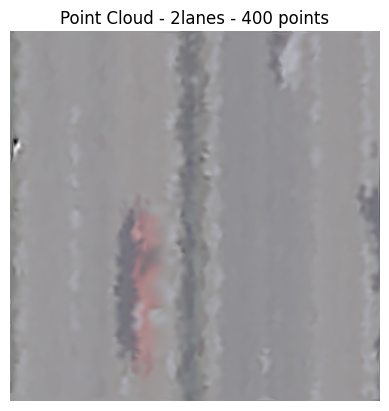

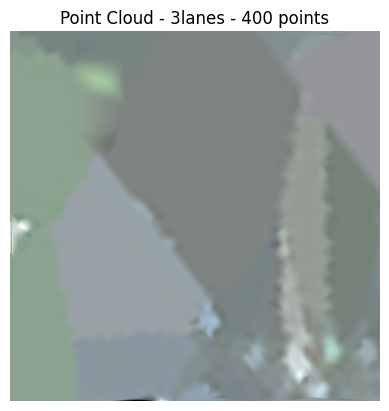

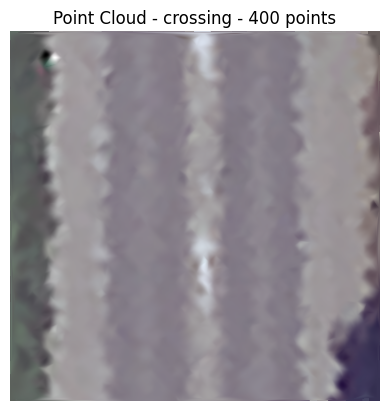

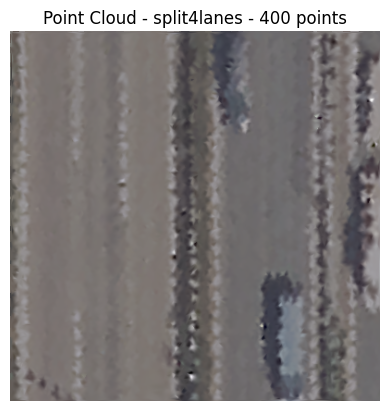

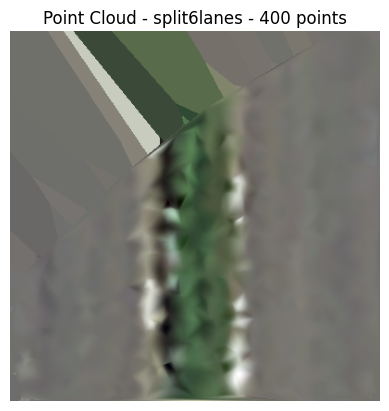

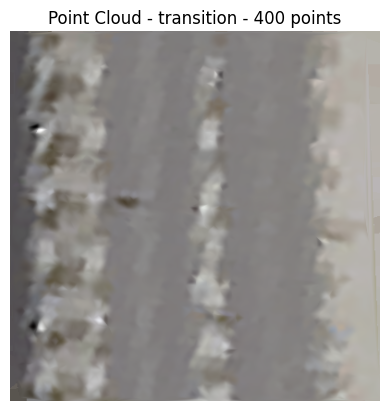

Epoch 1/15 - Train Loss: 2.0213, Train Acc: 0.2921, Test Acc: 0.4105
Epoch 2/15 - Train Loss: 1.5425, Train Acc: 0.3991, Test Acc: 0.4421
Epoch 3/15 - Train Loss: 1.4820, Train Acc: 0.4360, Test Acc: 0.4386
Epoch 4/15 - Train Loss: 1.3959, Train Acc: 0.4368, Test Acc: 0.4596
Epoch 5/15 - Train Loss: 1.3301, Train Acc: 0.4684, Test Acc: 0.4982
Epoch 6/15 - Train Loss: 1.3244, Train Acc: 0.4623, Test Acc: 0.5298
Epoch 7/15 - Train Loss: 1.2770, Train Acc: 0.4781, Test Acc: 0.5193
Epoch 8/15 - Train Loss: 1.2327, Train Acc: 0.4991, Test Acc: 0.5018


In [ ]:
# --- Main Execution --- (Jonas)
# load prepared dataser if available
if os.path.exists("prepared_dataset.npz"):
    data = np.load("prepared_dataset.npz")
    X, y = data['X'], data['y']
    print(f"Loaded prepared dataset with shape: {X.shape}, Labels shape: {y.shape}")
else:
    labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
    # folder_path = "C:/Users/jonas/OneDrive/Dokumente/Studium/Master/SoSe 2025/Machine Learning for Civil Engineering/Group Project/4_Road_point_cloud_classification/dataset/"  # Adjust the folder path as needed
    dataset = load_point_clouds(labels)  # Load point clouds from the specified folder
    img_size = (400, 400)  # Define the size of the output images
    # Prepare the dataset for deep learning
    X, y = prepare_dataset(dataset, img_size=img_size)
    # Save the prepared dataset to a file
    np.savez("prepared_dataset.npz", X=X, y=y)
    
# Optionally visualize the first point cloud from each category as an image
for i, label in enumerate(labels):
    show_image(X_train[i], title=f"Point Cloud - {label} - {X_train[i].shape[0]} points")

# Build the CNN model
input_shape = (3, img_size)  # Assuming RGB images of size


# Convert images and labels to torch tensors and reshape for CNN input
# Assume X, y are numpy arrays from prepare_dataset(), X.shape = (N, H, W, 3)
X = np.transpose(X, (0, 3, 1, 2))  # (N, 3, H, W)
X_tensor = torch.tensor(X, dtype=torch.float32)  #changed it to float32 to avoid memory loss issues
y_tensor = torch.tensor(y, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# Wrap in DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define input shape and number of classes for the CNN
input_shape = (3, X.shape[2], X.shape[3])  # (C, H, W)
num_classes = len(np.unique(y))
model = CNN(input_shape, num_classes)

# Train the model
train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001)
evaluate_model(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), class_names=labels)


# RandLANet
Finally, after some literature research, we came up with the idea to classify our dataset by using an adapted version of the semantic segmentation model RandLANet.